In [31]:
from __future__ import annotations

import os
from pathlib import Path
from black import out

import numpy as np
from matplotlib import pyplot as plt

from core import cat_aligner, config, utils

from PIL import ImageOps, Image
import IPython.display


In [2]:
aligner = cat_aligner.CatAlignerSimple
n_samples = 100

all_files = utils.Paths.list_sorted_files()
files = all_files[:n_samples]
names = [f.image.stem[4:] for f in files]


In [3]:
arr = utils.parse_image(files[0].image)
print(arr.shape)
print(arr[:, :, 0])

(500, 375, 3)
[[115 115 121 ... 138 137 137]
 [116 107 115 ... 138 138 137]
 [117 108 101 ... 137 136 136]
 ...
 [119 130 118 ...  45  37  39]
 [ 94  95  92 ...  52  51  53]
 [ 93  70  81 ...  56  56  60]]


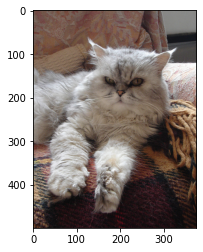

In [4]:
plt.imshow(arr)

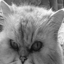

In [5]:
images = [ImageOps.grayscale(aligner.align_one_image(f, 64, 64)) for f in files]
shape = np.array(images[0]).shape
images[0]

In [6]:
X_train = np.array([np.array(im).flatten() for im in images])
X_train

array([[244, 222, 212, ..., 130, 152, 166],
       [  0,   0,   0, ..., 104, 111, 125],
       [ 26,  27,  21, ...,  90, 128, 111],
       ...,
       [ 83,  81,  79, ..., 195, 192, 190],
       [  0,   0,   0, ...,  26,  25,  26],
       [ 25,  31,  24, ..., 103,  78,  81]], dtype=uint8)

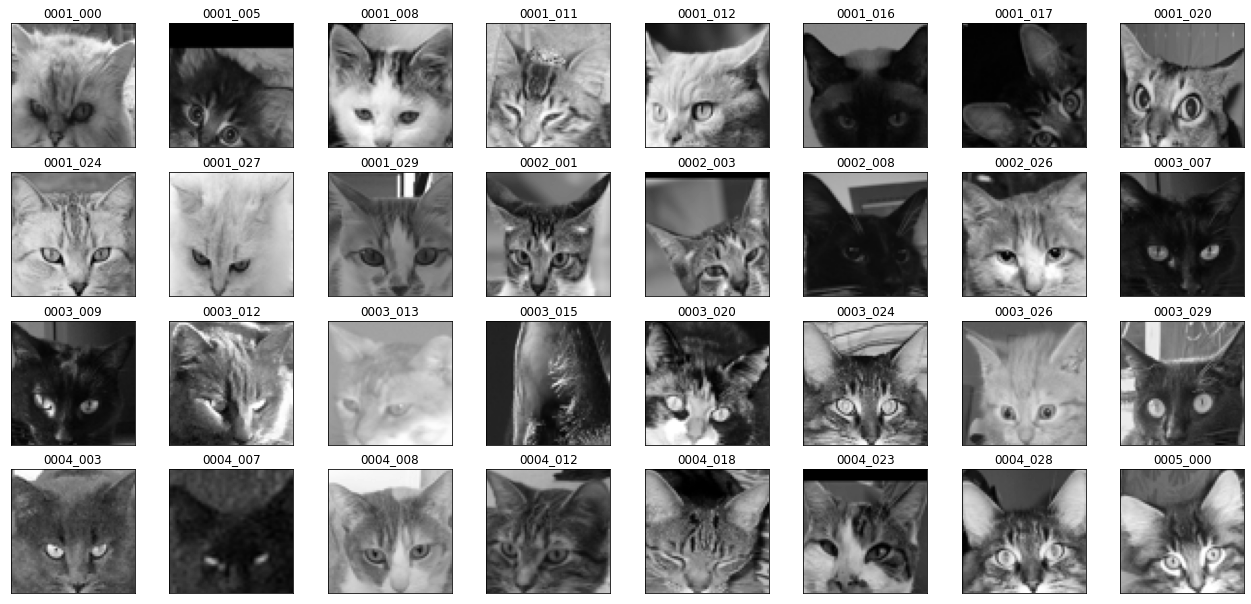

In [7]:
utils.plot_portraits(X_train, shape, 4, 8, titles=names)

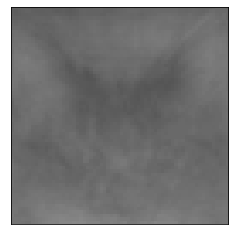

In [14]:
X_mean = X_train.mean(axis=0).astype('uint8')
utils.plot_image(X_mean, shape=shape)

In [15]:
def dilate_components(arr: np.ndarray) -> np.ndarray:
    ret = arr.copy()
    ret = ret - ret.min()
    ret = ret / ret.max()
    return ret

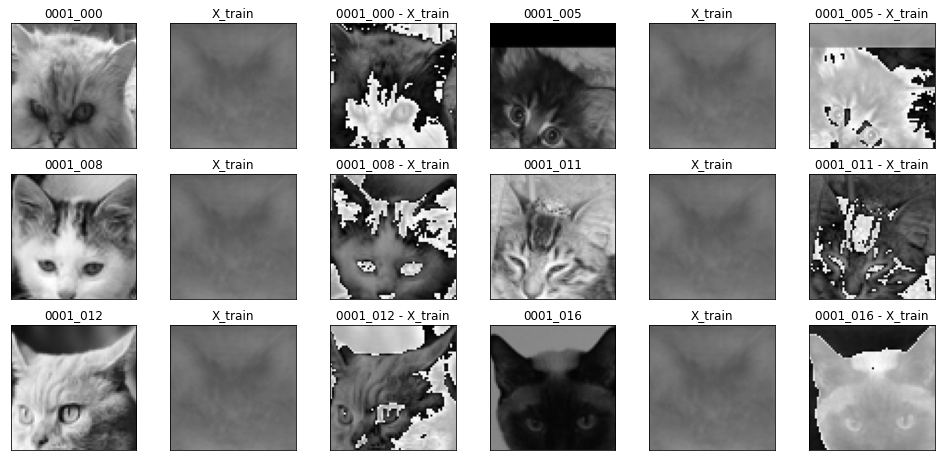

In [16]:
portraits, titles = [], []
for i in range(6):
    portraits.extend([X_train[i], X_mean, X_train[i] - X_mean])
    titles.extend([names[i], 'X_train', f'{names[i]} - X_train'])
utils.plot_portraits(portraits, shape, 3, 6, titles=titles)

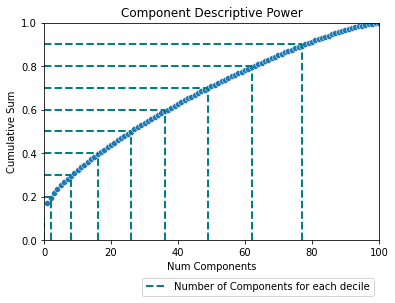

In [18]:
U, S, Vt = np.linalg.svd(X_train - X_mean, full_matrices=False)

utils.plot_principle_components(S)



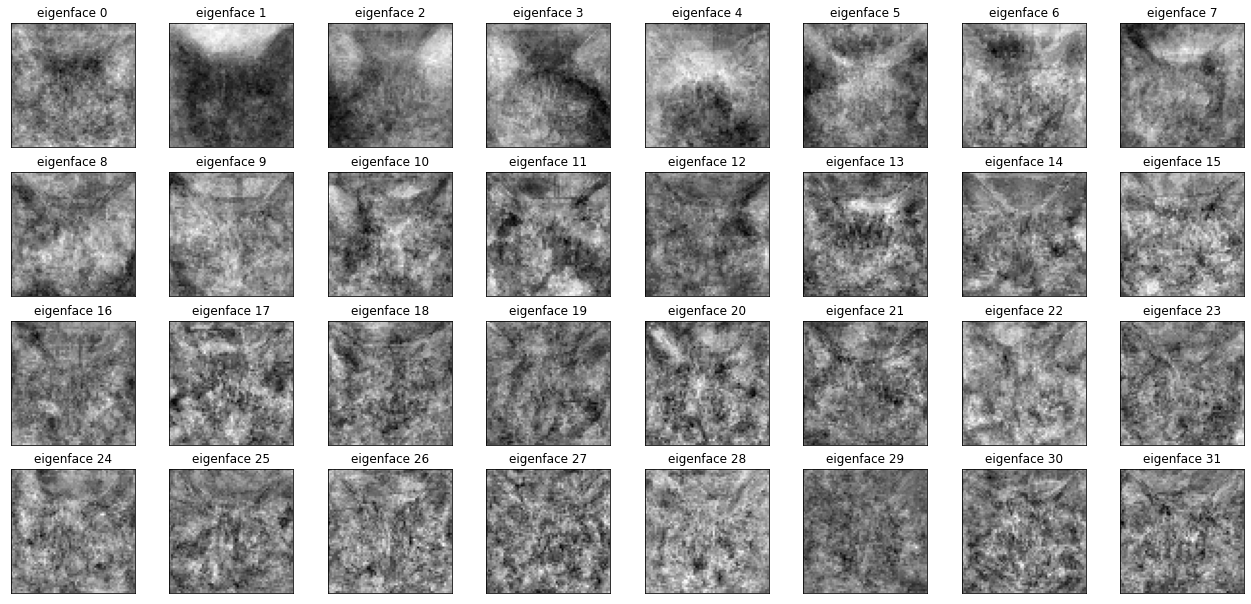

In [23]:
eigenfaces = np.array([dilate_components(arr) for arr in Vt])
eigenface_titles = [f"eigenface {i}" for i in range(eigenfaces.shape[0])]
utils.plot_portraits(eigenfaces, shape, 4, 8, eigenface_titles)

In [28]:
def reconstruct_with_components(
    image: int | slice | list[int], component: int | slice
):
    principle_compoents = U[image, component] * S[component]
    principle_directions = Vt[component]

    return (principle_compoents @ principle_directions) + X_mean

out_folder = Path('/tmp')
gif_folder = out_folder / "gif_subimages"
gif_folder.mkdir(exist_ok=True)

S_cum = S.cumsum() / S.sum()

percentiles = [1]
for x in np.arange(0, 1, 0.02):
    idx = np.searchsorted(S_cum, x)
    if idx > percentiles[-1]:
        percentiles.append(idx)

for n_components in percentiles:

    X_final = reconstruct_with_components(slice(32), slice(n_components))
    fig = utils.plot_portraits(
        X_final, shape, 4, 8, titles=names, suptitle=f"{n_components} Components"
    )
    out_folder.mkdir(exist_ok=True)
    fig.savefig(gif_folder / f"{n_components}_components.png")

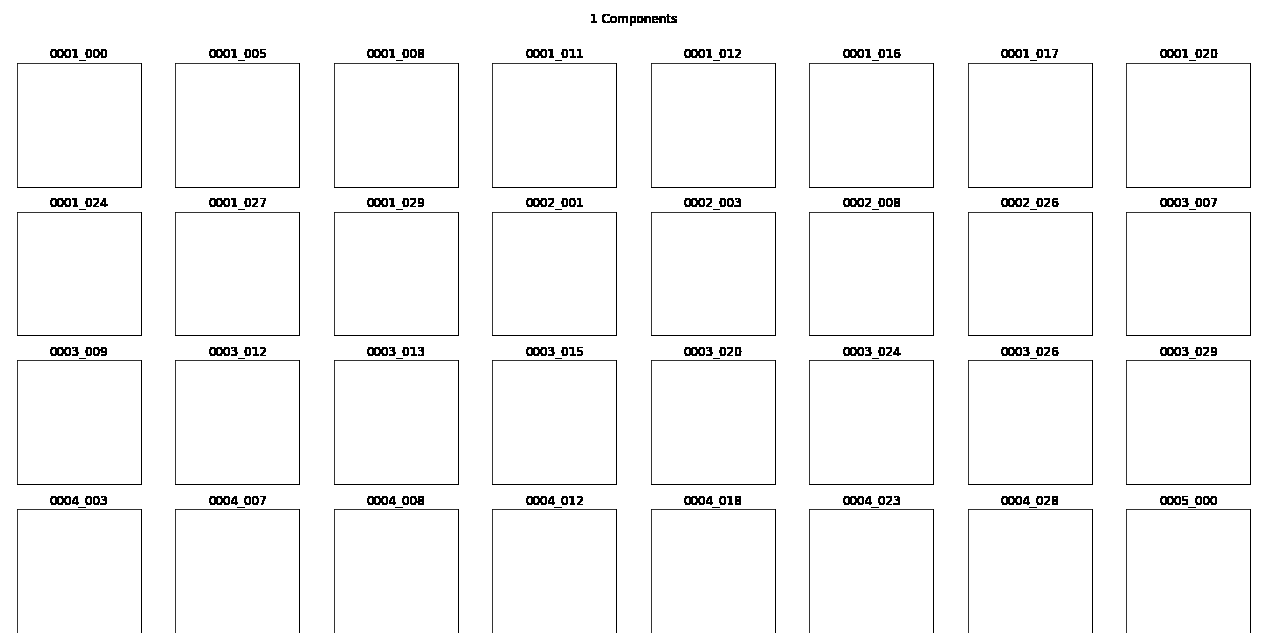

In [38]:
def save_gif(*, outpath: Path, subimage_dir: Path) -> Path:
    def key(path: Path) -> int:
        return int(path.stem[: path.stem.find("_")])

    files = sorted(subimage_dir.iterdir(), key=key)
    img, *imgs = [Image.open(f) for f in files]

    img.save(
        fp=outpath,
        format="GIF",
        append_images=imgs,
        save_all=True,
        duration=200,
        loop=0,
    )

    return outpath
    
gif_path = save_gif(outpath=out_folder / "iterative_components.gif", subimage_dir=gif_folder)

IPython.display.Image(gif_path)

# Cat Presentation

Yu Tomita and John McCloskey

![my image](images/00000100_014.jpg)

# Outline

# Human Face Recognition - John/Yu

# Cat Dataset - Yu

## What points mean

# Project Flow - Yu

# Dataset Cleaning - Yu

## Simple Cat Aligner

## Eye Based Cat Aligner

## LSTSQ Cat Aligner

# PCA Decomposition - John 

## Construct Training Data

- We use our aligner to create one row for each file, 64x64 long in grayscale (0-255)

In [ ]:
    all_files = list(utils.Paths.gen_files())
    files = all_files[:n_samples]
    images = [ImageOps.grayscale(aligner.align_one_image(f, 64, 64)) for f in files]
    shape = np.array(images[0]).shape
    X_train = np.array([np.array(im).flatten() for im in images])


## SVD

- We get the average image X_mean and subtract it from each image, then take SVD

In [ ]:
    X_mean = X_train.mean(axis=0)
    U, S, Vt = np.linalg.svd(X_train - X_mean, full_matrices=False)


- Note: U.shape = (9997, 4096). 9997 images, 4096 pixels each.

-       Vt.Shape = (4096, 4096). Only 4096 principle components

### Get Eigenfaces

- Vt is our principle components, so we expand the first 16 back into images to show 

In [ ]:
    eigenfaces = np.array([dilate_components(arr) for arr in Vt])
    eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
    ret = utils.plot_portraits(eigenfaces, shape, 4, 4, eigenface_titles)


## Reconstruct for Each Percentile

- We then reconstruct each image, using a subset of components with each

- TODO: add more depth here

In [ ]:
    def reconstruct_with_components(image: int | slice, component: int | slice):
        principle_components = U[image, component] * S[component]
        principle_directions = Vt[component]

        return (principle_components @ principle_directions) + X_mean


- Then we construct a nice gif for percentile of principle components

In [ ]:
    for n_components in percentiles:
        X_final = reconstruct_with_components(slice(10, 30), slice(n_components))
        fig = utils.plot_portraits(...)


# Results - John

# simple

## simple: sample_processed_images
<center><img src="images/simple/sample_processed_images.png"></center>


## simple: eigenfaces
<center><img src="images/simple/eigenfaces.png"></center>


## simple: Principle Components
<center><img src="images/simple/Principle Components.png"></center>


## simple: iterative_components
<center><img src="images/simple/iterative_components.gif"></center>


# eyes

## eyes: sample_processed_images
<center><img src="images/eyes/sample_processed_images.png"></center>


## eyes: eigenfaces
<center><img src="images/eyes/eigenfaces.png"></center>


## eyes: Principle Components
<center><img src="images/eyes/Principle Components.png"></center>


## eyes: iterative_components
<center><img src="images/eyes/iterative_components.gif"></center>


# lstsq_1000

## lstsq_1000: sample_processed_images
<center><img src="images/lstsq_1000/sample_processed_images.png"></center>


## lstsq_1000: eigenfaces
<center><img src="images/lstsq_1000/eigenfaces.png"></center>


## lstsq_1000: Principle Components
<center><img src="images/lstsq_1000/Principle Components.png"></center>


## lstsq_1000: iterative_components
<center><img src="images/lstsq_1000/iterative_components.gif"></center>


# lstsq

## lstsq: sample_processed_images
<center><img src="images/lstsq/sample_processed_images.png"></center>


## lstsq: eigenfaces
<center><img src="images/lstsq/eigenfaces.png"></center>


## lstsq: Principle Components
<center><img src="images/lstsq/Principle Components.png"></center>


## lstsq: iterative_components
<center><img src="images/lstsq/iterative_components.gif"></center>


# Conclusion - John

- Simple works decently

- Eyes and Least Squares give much better eigenfaces

- The number of components needed to account for all the noise stays consistent

# Future Directions

- Use distance from each eigenvector as labels to train a model that would then classify cats into prospective types (to decompose our own cats)

- Use clustering to cluster groups of cats in the first few PCA dimensions and fine commonalities

- TODO: try not taking out the mean

- TODO: try taking both curves together and look at them

- TODO: 10_000 LSTSQ

- JTODO: sideways cat

- TODO: list sorted files